In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

The following code assumes a fixed starting point and a fixed terminal point for each episode.

          Q(0,L)  Q(0,R)   Q(1,L)  Q(1,R)  Q(2,L)    Q(2,R)    Q(3,L)  \
Episode                                                                 
1        0.00000  0.0000  0.00000   0.000  0.0000  0.000000  0.000000   
2        0.00000  0.0000  0.00000   0.000  0.0000  0.000000  0.000000   
3        0.00000  0.0000  0.00000   0.000  0.0000  0.361179  0.175033   
4        0.00000  0.0000  0.00000   0.000  0.0000  0.552882  0.175033   
5        0.00000  0.0000  0.00000   0.000  0.0000  0.685407  0.175033   
...          ...     ...      ...     ...     ...       ...       ...   
496      0.59049  0.6561  0.59049   0.729  0.6561  0.810000  0.729000   
497      0.59049  0.6561  0.59049   0.729  0.6561  0.810000  0.729000   
498      0.59049  0.6561  0.59049   0.729  0.6561  0.810000  0.729000   
499      0.59049  0.6561  0.59049   0.729  0.6561  0.810000  0.729000   
500      0.59049  0.6561  0.59049   0.729  0.6561  0.810000  0.729000   

           Q(3,R)  Q(4,L)   Q(4,R)  Q(5,L)  Q(5,R)

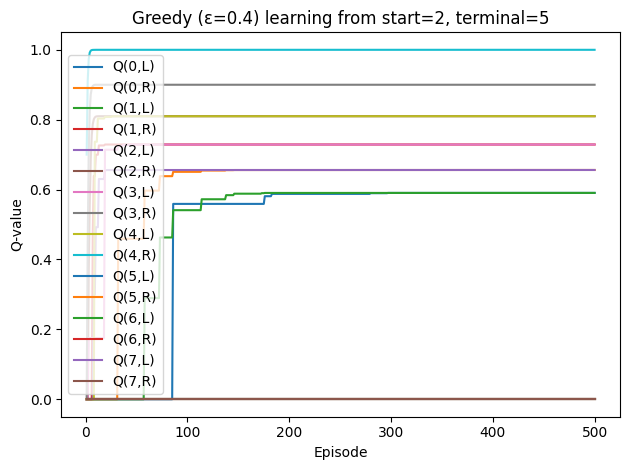

,L,R
0,0.59049,0.6561
1,0.59049,0.7290
2,0.65610,0.8100
3,0.72900,0.9000
4,0.81000,1.0000
5,0.00000,0.0000
6,0.00000,0.0000
7,0.00000,0.0000


The path from start state at 2 to terminal state at 5 is: [2, 3, 4, 5]


In [2]:
ACTIONS = {"L": -1, "R": +1}

def is_terminal(state, terminal_state):
    return state == terminal_state

def step(state, action, states, terminal_state, reward):
    if is_terminal(state, terminal_state):
        return state, 0.0, True
    move = ACTIONS[action]
    next_state = min(max(state + move, min(states)), max(states))
    r = reward if next_state == terminal_state else 0.0
    done = (next_state == terminal_state)
    return next_state, r, done

def greedy_action(state, Q, states, terminal_state, epsilon):
    """ε-greedy with optional override for evaluation."""
    if is_terminal(state, terminal_state):
        return None
    eps = epsilon

    if np.random.rand() < eps:
        return np.random.choice(list(ACTIONS.keys()))
    # greedy tie-break
    q_values = {a: Q[(state, a)] for a in ACTIONS}
    max_q = max(q_values.values())
    best = [a for a, q in q_values.items() if q == max_q]
    return np.random.choice(best)

def rollout_greedy_path(start, Q, states, terminal_state, max_steps=50):
    """
    Roll out the learned policy. If start is None, pick a random non-terminal
    start (mirrors exploring starts). Uses ε=0 for evaluation.
    """
    s = start

    path = [s]
    steps = 0
    while not is_terminal(s, terminal_state) and steps < max_steps:
        a = greedy_action(s, Q, states, terminal_state, epsilon=0.0)  # force pure greedy
        if a is None:
            break
        s_next, _, _ = step(s, a, states, terminal_state, reward)
        path.append(s_next)
        s = s_next
        steps += 1
    return path



def q_update(s, a, r, s_next, Q, gamma, alpha, terminal_state):
    max_next = 0.0 if is_terminal(s_next, terminal_state) else max(Q[(s_next, "L")], Q[(s_next, "R")])
    target = r + gamma * max_next
    Q[(s, a)] = Q[(s, a)] + alpha * (target - Q[(s, a)]) # update Q-value
    return target

def run_training_fix_start(states, terminal_state, alpha, gamma, episodes, start_state, epsilon, reward):
    records = []
    Q = {(s, a): 0.0 for s in states for a in ACTIONS}

    for ep in range(1, episodes+1):
        s = start_state
        steps = 0
        # run until terminal
        while not is_terminal(s, terminal_state) and steps < 50:
            a = greedy_action(s, Q, states, terminal_state, epsilon)
            s_next, r, done = step(s, a, states, terminal_state, reward)
            q_update(s, a, r, s_next, Q, gamma, alpha, terminal_state)
            s = s_next
            steps += 1

        # record requested Q entries after this episode

        rec = {
            "Episode": ep,
            **{f"Q({s},{a})": Q[(s, a)] for s in states for a in ACTIONS}
        }
        records.append(rec)

    df = pd.DataFrame(records).set_index("Episode")

    # display_dataframe_to_user("Greedy (ε=0) Q-table after each episode", df)
    print(df)

    # plot the evolving values for the two actions that actually change
    plt.figure()
    for s,a in itertools.product(states, ACTIONS):
        plt.plot(df.index, df[f"Q({s},{a})"], label=f"Q({s},{a})")

    plt.xlabel("Episode")
    plt.ylabel("Q-value")
    plt.title(f"Greedy (ε={epsilon}) learning from start={start_state}, terminal={terminal_state}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Return final row for convenience
    return df.tail(1), Q

np.random.seed(43)  # for reproducibility
states = list(range(0,8))
terminal_state = 5
start_state = 2

alpha = 0.7
gamma = 0.9
epsilon = 0.4
episodes = 500
reward = 1

final_q_table, Q = run_training_fix_start(states, terminal_state, alpha, gamma, episodes, start_state, epsilon, reward)

# Display final Q
data = []
for state in states:
    row_data = {}
    for action in ACTIONS:
        row_data[action] = Q.get((state, action), 0.0)
    data.append(row_data)

# Create the DataFrame
df_export = pd.DataFrame(data, index=states)

# Set the column names explicitly to match the ACTIONS dictionary keys
df_export.columns = ACTIONS.keys()

display(df_export)

path = rollout_greedy_path(start_state, Q, states, terminal_state)
print(f"The path from start state at {start_state} to terminal state at {terminal_state} is:", path)

The following code assumes a random starting point at the beginning of each episode.

In [4]:
def run_training(states, terminal_state, alpha, gamma, episodes, epsilon, reward):
    records = []
    Q = {(s, a): 0.0 for s in states for a in ACTIONS}
    non_terminal_starts = [s for s in states if s != terminal_state]

    for ep in range(1, episodes + 1):
        s = np.random.choice(non_terminal_starts)  # random start each episode
        steps = 0
        while not is_terminal(s, terminal_state) and steps < 50:
            a = greedy_action(s, Q, states, terminal_state, epsilon)  # your ε-greedy
            s_next, r, done = step(s, a, states, terminal_state, reward)
            q_update(s, a, r, s_next, Q, gamma, alpha, terminal_state)
            s = s_next
            steps += 1

        rec = {"Episode": ep, **{f"Q({s},{a})": Q[(s, a)] for s in states for a in ACTIONS}}
        records.append(rec)


    df = pd.DataFrame(records).set_index("Episode")

    # display_dataframe_to_user("Greedy (ε=0) Q-table after each episode", df)
    print(df)

    return Q

# --- Run ---
np.random.seed(43)  # for reproducibility
states = list(range(0,8))
terminal_state = 5

alpha = 0.7
gamma = 0.9
epsilon = 0.4
episodes = 2000
reward = 1
Q = run_training(states, terminal_state, alpha, gamma, episodes, epsilon, reward)

# Display final Q
data = []
for state in states:
    row_data = {}
    for action in ACTIONS:
        row_data[action] = Q.get((state, action), 0.0)
    data.append(row_data)

# Create the DataFrame
df_export = pd.DataFrame(data, index=states)

# Set the column names explicitly to match the ACTIONS dictionary keys
df_export.columns = ACTIONS.keys()

display(df_export)



          Q(0,L)  Q(0,R)   Q(1,L)  Q(1,R)  Q(2,L)  Q(2,R)  Q(3,L)  Q(3,R)  \
Episode                                                                     
1        0.00000  0.0000  0.00000   0.000  0.0000    0.00   0.000   0.000   
2        0.00000  0.0000  0.00000   0.000  0.0000    0.00   0.000   0.000   
3        0.00000  0.0000  0.00000   0.000  0.0000    0.00   0.000   0.441   
4        0.00000  0.0000  0.00000   0.000  0.0000    0.00   0.000   0.441   
5        0.00000  0.0000  0.00000   0.000  0.0000    0.00   0.000   0.441   
...          ...     ...      ...     ...     ...     ...     ...     ...   
1996     0.59049  0.6561  0.59049   0.729  0.6561    0.81   0.729   0.900   
1997     0.59049  0.6561  0.59049   0.729  0.6561    0.81   0.729   0.900   
1998     0.59049  0.6561  0.59049   0.729  0.6561    0.81   0.729   0.900   
1999     0.59049  0.6561  0.59049   0.729  0.6561    0.81   0.729   0.900   
2000     0.59049  0.6561  0.59049   0.729  0.6561    0.81   0.729   0.900   

,L,R
0,0.59049,0.6561
1,0.59049,0.7290
2,0.65610,0.8100
3,0.72900,0.9000
4,0.81000,1.0000
5,0.00000,0.0000
6,1.00000,0.8100
7,0.90000,0.8100


This section implements the environment where the agent can move left or right indefinitely. The terminal state is at 0.

In [5]:
np.random.seed(43)  # for reproducibility
states = list(range(-20,21))
terminal_state = 0

alpha = 0.7
gamma = 0.9
epsilon = 0.4
episodes = 2000
reward = 1
Q = run_training(states, terminal_state, alpha, gamma, episodes, epsilon, reward)

# Display final Q
data = []
for state in states:
    row_data = {}
    for action in ACTIONS:
        row_data[action] = Q.get((state, action), 0.0)
    data.append(row_data)

# Create the DataFrame
df_export = pd.DataFrame(data, index=states)

# Set the column names explicitly to match the ACTIONS dictionary keys
df_export.columns = ACTIONS.keys()

display(df_export)



         Q(-20,L)  Q(-20,R)  Q(-19,L)  Q(-19,R)  Q(-18,L)  Q(-18,R)  Q(-17,L)  \
Episode                                                                         
1        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
...           ...       ...       ...       ...       ...       ...       ...   
1996     0.121577  0.135085  0.121577  0.150095  0.135085  0.166772  0.150095   
1997     0.121577  0.135085  0.121577  0.150095  0.135085  0.166772  0.150095   
1998     0.121577  0.135085  0.121577  0.150095  0.135085  0.166772  0.150095   
1999     0.121577  0.135085  0.121577  0.150095  0.135085  0.166772  0.150095   
2000     0.121577  0.135085 

,L,R
-20,0.121577,0.135085
-19,0.121577,0.150095
-18,0.135085,0.166772
-17,0.150095,0.185302
-16,0.166772,0.205891
-15,0.185302,0.228768
-14,0.205891,0.254187
-13,0.228768,0.282430
-12,0.254187,0.313811
-11,0.282430,0.348678
